In [ ]:
# ============================================================================
# Advanced 3D Tooth Segmentation with MONAI - ToothFairy Dataset
# ============================================================================

# ------------------------------------------------------------------
# 1️⃣ Environment Setup
# ------------------------------------------------------------------
!pip install monai[all] nibabel tqdm matplotlib SimpleITK scikit-learn tensorboard -q

# ------------------------------------------------------------------
# 2️⃣ Imports
# ------------------------------------------------------------------
import os
import json
import random
import numpy as np
import torch
import torch.nn as nn
import nibabel as nib
from pathlib import Path
from glob import glob
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import monai
from monai.transforms import (
    Compose, LoadImaged, ScaleIntensityd, ScaleIntensityRanged,
    RandFlipd, RandRotate90d, RandAffined, RandGaussianNoised,
    RandGaussianSmoothd, RandScaleIntensityd, RandShiftIntensityd,
    CropForegroundd, ResizeWithPadOrCropd, EnsureChannelFirstd,
    Orientationd, Spacingd, RandCropByPosNegLabeld, AsDiscreted
)
from monai.networks.nets import SegResNet, SwinUNETR, UNet
from monai.losses import DiceCELoss, DiceLoss, FocalLoss
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.data import Dataset, DataLoader, CacheDataset, decollate_batch
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism

from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
# ------------------------------------------------------------------
# 3 Configuration & Seeds
# ------------------------------------------------------------------
class Config:
    # Paths
    BASE_DIR = Path("/kaggle/input/tooth-fairy-2-dataset/Dataset112_ToothFairy2")
    IMG_DIR = BASE_DIR / "imagesTr"
    LAB_DIR = BASE_DIR / "labelsTr"
    JSON_PATH = BASE_DIR / "dataset.json"
    OUTPUT_DIR = Path("/kaggle/working")
    CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
    LOG_DIR = OUTPUT_DIR / "logs"
    
    # Model
    MODEL_NAME = "SwinUNETR"  # Options: "SegResNet", "SwinUNETR", "UNet"
    SPATIAL_SIZE = (64, 64, 64)  # Adjust based on GPU memory
    IN_CHANNELS = 1
    OUT_CHANNELS = 49
    
    # Training
    SEED = 42
    BATCH_SIZE = 2
    NUM_EPOCHS = 15
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    VAL_INTERVAL = 1  # Validate every N epochs
    SAVE_INTERVAL = 1  # Save checkpoint every N epochs
    
    # Augmentation
    CACHE_RATE = 0.2  # Cache 50% of data in RAM
    NUM_WORKERS = 4
    
    # Inference
    SW_BATCH_SIZE = 1
    INFER_OVERLAP = 0.2
    
    # Loss weights (higher for teeth vs background/anatomical structures)
    CLASS_WEIGHTS = None  # Will be calculated from data
    
    # Device
    USE_AMP = True  # Automatic Mixed Precision

# Create directories
Config.CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
Config.LOG_DIR.mkdir(parents=True, exist_ok=True)

# Set seeds
set_determinism(seed=Config.SEED)
random.seed(Config.SEED)
np.random.seed(Config.SEED)
torch.manual_seed(Config.SEED)
torch.cuda.manual_seed_all(Config.SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Model: {Config.MODEL_NAME}")
print(f"Spatial Size: {Config.SPATIAL_SIZE}")


🚀 Using device: cuda
📊 Model: SwinUNETR
🎯 Spatial Size: (64, 64, 64)


In [ ]:
# ------------------------------------------------------------------
# 4 Label Definitions & Grouping
# ------------------------------------------------------------------
LABEL_NAMES = {
    0: "Background",
    1: "Lower Jawbone", 2: "Upper Jawbone",
    3: "Left Inferior Alveolar Canal", 4: "Right Inferior Alveolar Canal",
    5: "Left Maxillary Sinus", 6: "Right Maxillary Sinus",
    7: "Pharynx", 8: "Bridge", 9: "Crown", 10: "Implant",
    11: "Upper Right Central Incisor", 12: "Upper Right Lateral Incisor",
    13: "Upper Right Canine", 14: "Upper Right First Premolar",
    15: "Upper Right Second Premolar", 16: "Upper Right First Molar",
    17: "Upper Right Second Molar", 18: "Upper Right Third Molar",
    21: "Upper Left Central Incisor", 22: "Upper Left Lateral Incisor",
    23: "Upper Left Canine", 24: "Upper Left First Premolar",
    25: "Upper Left Second Premolar", 26: "Upper Left First Molar",
    27: "Upper Left Second Molar", 28: "Upper Left Third Molar",
    31: "Lower Left Central Incisor", 32: "Lower Left Lateral Incisor",
    33: "Lower Left Canine", 34: "Lower Left First Premolar",
    35: "Lower Left Second Premolar", 36: "Lower Left First Molar",
    37: "Lower Left Second Molar", 38: "Lower Left Third Molar",
    41: "Lower Right Central Incisor", 42: "Lower Right Lateral Incisor",
    43: "Lower Right Canine", 44: "Lower Right First Premolar",
    45: "Lower Right Second Premolar", 46: "Lower Right First Molar",
    47: "Lower Right Second Molar", 48: "Lower Right Third Molar"
}

# Group labels for better analysis
ANATOMICAL_LABELS = list(range(1, 11))  # Jawbones, canals, etc.
TOOTH_LABELS = [i for i in range(11, 49) if i not in [19, 20, 29, 30, 39, 40]]
UPPER_TEETH = [i for i in range(11, 29) if i not in [19, 20]]
LOWER_TEETH = [i for i in range(31, 49) if i not in [39, 40]]

print(f"Total classes: {Config.OUT_CHANNELS}")
print(f"Teeth classes: {len(TOOTH_LABELS)}")
print(f"Anatomical classes: {len(ANATOMICAL_LABELS)}")


📋 Total classes: 49
🦷 Teeth classes: 32
🏥 Anatomical classes: 10


In [ ]:
# ------------------------------------------------------------------
# 5 Data Loading & Preparation
# ------------------------------------------------------------------
def build_file_dicts():
    """Build list of image-label pairs"""
    images = sorted(glob(str(Config.IMG_DIR / "*.mha")))
    labels = sorted(glob(str(Config.LAB_DIR / "*.mha")))
    
    assert len(images) == len(labels), f"Mismatch! {len(images)} images vs {len(labels)} labels"
    
    file_dicts = []
    for img_path, lbl_path in zip(images, labels):
        file_dicts.append({"image": img_path, "label": lbl_path})
    
    return file_dicts

file_dicts = build_file_dicts()
print(f"Prepared {len(file_dicts)} image-label pairs")

# Train/Val Split
train_dicts, val_dicts = train_test_split(
    file_dicts, test_size=0.2, random_state=Config.SEED, shuffle=True
)
print(f"Train: {len(train_dicts)} | Val: {len(val_dicts)}")

# ------------------------------------------------------------------
# 6 Advanced Transforms
# ------------------------------------------------------------------
train_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader="ITKReader", image_only=False),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest")
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000, a_max=3000,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    
    # Spatial augmentations
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=Config.SPATIAL_SIZE,
        pos=2,  # 2x more positive samples
        neg=1,
        num_samples=2,
        image_key="image",
        image_threshold=0,
    ),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=2, prob=0.5),
    RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3),
    RandAffined(
        keys=["image", "label"],
        prob=0.5,
        rotate_range=(np.pi/36, np.pi/36, np.pi/36),
        scale_range=(0.1, 0.1, 0.1),
        mode=("bilinear", "nearest"),
        padding_mode="border"
    ),
    
    # Intensity augmentations
    RandGaussianNoised(keys=["image"], prob=0.15, mean=0.0, std=0.1),
    RandGaussianSmoothd(
        keys=["image"],
        sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0), sigma_z=(0.5, 1.0),
        prob=0.15
    ),
    RandScaleIntensityd(keys=["image"], factors=0.1, prob=0.5),
    RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
])



val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader="ITKReader"),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0),
        mode=("bilinear", "nearest")
    ),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1000, a_max=3000,
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    # Add cropping to validation - this is the key change!
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=Config.SPATIAL_SIZE,
        pos=1,
        neg=1,
        num_samples=1,  # Just 1 sample per volume for validation
        image_key="image",
        image_threshold=0,
    ),
])

# ------------------------------------------------------------------
# 7 Datasets & DataLoaders
# ------------------------------------------------------------------
print("Creating datasets...")
train_ds = CacheDataset(
    data=train_dicts,
    transform=train_transforms,
    cache_rate=Config.CACHE_RATE,
    num_workers=Config.NUM_WORKERS
)

val_ds = CacheDataset(
    data=val_dicts,
    transform=val_transforms,
    cache_rate=0.1,  # Cache all validation data
    num_workers=Config.NUM_WORKERS
)

train_loader = DataLoader(
    train_ds,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
)

print("Datasets ready!")


monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


✅ Prepared 480 image-label pairs
📊 Train: 384 | Val: 96
🔄 Creating datasets...


Loading dataset: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s]

✅ Datasets ready!


In [ ]:
# ------------------------------------------------------------------
# 8 Model Selection
# ------------------------------------------------------------------
def get_model(model_name):
    """Get model based on configuration"""
    if model_name == "SegResNet":
        model = SegResNet(
            spatial_dims=3,
            in_channels=Config.IN_CHANNELS,
            out_channels=Config.OUT_CHANNELS,
            init_filters=32,
            blocks_down=[1, 2, 2, 4],
            blocks_up=[1, 1, 1],
            dropout_prob=0.2,
        )
    elif model_name == "SwinUNETR":
        model = SwinUNETR(
            in_channels=Config.IN_CHANNELS,
            out_channels=Config.OUT_CHANNELS,
            feature_size=48,
            use_checkpoint=True,
            use_v2=True
        )
    elif model_name == "UNet":
        model = UNet(
            spatial_dims=3,
            in_channels=Config.IN_CHANNELS,
            out_channels=Config.OUT_CHANNELS,
            channels=(32, 64, 128, 256, 512),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            dropout=0.2,
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model

model = get_model(Config.MODEL_NAME).to(device)
print(f"Model created: {Config.MODEL_NAME}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ------------------------------------------------------------------
# 9 Loss Function & Metrics
# ------------------------------------------------------------------
loss_function = DiceCELoss(
    to_onehot_y=True,
    softmax=True,
    squared_pred=True,
    smooth_nr=1e-5,
    smooth_dr=1e-5,
    batch=True
)

dice_metric = DiceMetric(
    include_background=False,
    reduction="mean_batch",
    get_not_nans=False
)

post_pred = Compose([AsDiscreted(keys="image", argmax=True, to_onehot=Config.OUT_CHANNELS)])
post_label = Compose([AsDiscreted(keys="label", to_onehot=Config.OUT_CHANNELS)])

# ------------------------------------------------------------------
# 10 Optimizer & Scheduler
# ------------------------------------------------------------------
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=Config.LEARNING_RATE,
    weight_decay=Config.WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6,
)

# Mixed Precision Training
scaler = GradScaler() if Config.USE_AMP else None

# TensorBoard
writer = SummaryWriter(Config.LOG_DIR)


🏗️ Model created: SwinUNETR
📊 Parameters: 72,764,371


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


In [ ]:
# ------------------------------------------------------------------
# 11 Training Utilities
# ------------------------------------------------------------------
class MetricsTracker:
    """Track and compute metrics"""
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.dice_scores = []
        self.losses = []
        
    def update(self, loss, dice):
        self.losses.append(loss)
        if dice is not None:
            self.dice_scores.append(dice)
    
    def get_average_dice(self):
        if len(self.dice_scores) == 0:
            return 0.0
        return np.mean(self.dice_scores)
    
    def get_average_loss(self):
        if len(self.losses) == 0:
            return 0.0
        return np.mean(self.losses)

def compute_class_dice(pred, label, num_classes):
    """Compute Dice per class"""
    dice_scores = []
    for c in range(1, num_classes):  # Skip background
        pred_c = (pred == c)
        label_c = (label == c)
        
        if label_c.sum() == 0:
            if pred_c.sum() == 0:
                dice_scores.append(1.0)  # True negative
            else:
                dice_scores.append(0.0)  # False positive
        else:
            intersection = (pred_c & label_c).sum()
            dice = (2.0 * intersection) / (pred_c.sum() + label_c.sum() + 1e-8)
            dice_scores.append(dice.item())
    
    return np.array(dice_scores)
# ------------------------------------------------------------------
# 12 Training Loop
# ------------------------------------------------------------------
def train_epoch(model, loader, optimizer, loss_fn, scaler, epoch):
    """Train for one epoch"""
    model.train()
    tracker = MetricsTracker()
    
    pbar = tqdm(loader, desc=f"Epoch {epoch}/{Config.NUM_EPOCHS}")
    for batch_idx, batch_data in enumerate(pbar):
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        
        optimizer.zero_grad()
        
        if Config.USE_AMP:
            with autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss = torch.nan_to_num(loss, nan=0.0)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        tracker.update(loss.item(), None)
        pbar.set_postfix({'loss': f"{tracker.get_average_loss():.4f}"})
    
    return tracker.get_average_loss()

def validate(model, loader, epoch):
    """Validate model - simple and memory efficient"""
    model.eval()
    tracker = MetricsTracker()
    all_dice_scores = []
    
    with torch.no_grad():
        for batch_data in tqdm(loader, desc="Validation"):
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            
            # Direct forward pass (no sliding window!)
            outputs = model(inputs)
            
            # Compute loss directly on GPU
            loss = loss_function(outputs, labels)
            
            # Move to CPU for metrics computation
            outputs_cpu = outputs.cpu()
            labels_cpu = labels.cpu()
            
            # Compute dice per class
            pred = torch.argmax(outputs_cpu, dim=1)
            class_dice = compute_class_dice(
                pred[0].numpy(),
                labels_cpu[0].numpy(),
                Config.OUT_CHANNELS
            )
            all_dice_scores.append(class_dice)
            
            tracker.update(loss.item(), np.mean(class_dice))
            
            # Clear GPU cache periodically
            if len(all_dice_scores) % 10 == 0:
                torch.cuda.empty_cache()
    
    # Aggregate metrics
    all_dice_scores = np.array(all_dice_scores)
    mean_dice_per_class = np.mean(all_dice_scores, axis=0)
    
    # Compute group metrics
    tooth_indices = [i-1 for i in TOOTH_LABELS if i < Config.OUT_CHANNELS]
    anat_indices = [i-1 for i in ANATOMICAL_LABELS if i < Config.OUT_CHANNELS]
    
    teeth_dice = np.mean(mean_dice_per_class[tooth_indices])
    anat_dice = np.mean(mean_dice_per_class[anat_indices])
    
    results = {
        'loss': tracker.get_average_loss(),
        'dice_mean': np.mean(mean_dice_per_class),
        'dice_teeth': teeth_dice,
        'dice_anatomical': anat_dice,
        'dice_per_class': mean_dice_per_class
    }
    
    return results


In [ ]:
# ------------------------------------------------------------------
# 13 Main Training
# ------------------------------------------------------------------
print("\nStarting training...")
best_dice = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_dice': []}

for epoch in range(1, Config.NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{Config.NUM_EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss = train_epoch(model, train_loader, optimizer, loss_function, scaler, epoch)
    # scheduler.step()
    
    # Validate
    if epoch % Config.VAL_INTERVAL == 0:
        val_results = validate(model, val_loader, epoch)
        
        # Log metrics
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_results['loss'], epoch)
        writer.add_scalar('Dice/mean', val_results['dice_mean'], epoch)
        writer.add_scalar('Dice/teeth', val_results['dice_teeth'], epoch)
        writer.add_scalar('Dice/anatomical', val_results['dice_anatomical'], epoch)
        writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)
        
        # Print results
        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_results['loss']:.4f}")
        print(f"  Val Dice (Mean): {val_results['dice_mean']:.4f}")
        print(f"  Val Dice (Teeth): {val_results['dice_teeth']:.4f}")
        print(f"  Val Dice (Anatomical): {val_results['dice_anatomical']:.4f}")
        
        # Save best model
        if val_results['dice_teeth'] > best_dice:
            best_dice = val_results['dice_teeth']
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_dice': best_dice,
                'config': Config.__dict__
            }
            torch.save(model, Config.CHECKPOINT_DIR / "best_model.pth")
            print(f"  New best model saved. Dice: {best_dice:.4f}")
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_results['loss'])
        history['val_dice'].append(val_results['dice_mean'])
    
    # Periodic checkpoint
    if epoch % Config.SAVE_INTERVAL == 0:
        torch.save(model, Config.CHECKPOINT_DIR / f"model_epoch_{epoch}.pth")

writer.close()
print("\nTraining completed!")
print(f"Best Dice Score: {best_dice:.4f}")



🚀 Starting training...

Epoch 1/15


Epoch 1/15:   0%|          | 0/192 [00:00<?, ?it/s]

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.9736
  Val Loss: 1.5837
  Val Dice (Mean): 0.9496
  Val Dice (Teeth): 0.9606
  Val Dice (Anatomical): 0.8843
  ✨ New best model saved! Dice: 0.9606

Epoch 2/15


Epoch 2/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.5057
  Val Loss: 1.3170
  Val Dice (Mean): 0.9530
  Val Dice (Teeth): 0.9701
  Val Dice (Anatomical): 0.8701
  ✨ New best model saved! Dice: 0.9701

Epoch 3/15


Epoch 3/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.4915
  Val Loss: 1.3365
  Val Dice (Mean): 0.9458
  Val Dice (Teeth): 0.9538
  Val Dice (Anatomical): 0.8878

Epoch 4/15


Epoch 4/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.4013
  Val Loss: 1.2886
  Val Dice (Mean): 0.9527
  Val Dice (Teeth): 0.9596
  Val Dice (Anatomical): 0.9022

Epoch 5/15


Epoch 5/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.2768
  Val Loss: 1.1137
  Val Dice (Mean): 0.9519
  Val Dice (Teeth): 0.9671
  Val Dice (Anatomical): 0.8744

Epoch 6/15


Epoch 6/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.2205
  Val Loss: 1.1190
  Val Dice (Mean): 0.9499
  Val Dice (Teeth): 0.9632
  Val Dice (Anatomical): 0.8772

Epoch 7/15


Epoch 7/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.1380
  Val Loss: 1.0598
  Val Dice (Mean): 0.9480
  Val Dice (Teeth): 0.9610
  Val Dice (Anatomical): 0.8752

Epoch 8/15


Epoch 8/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.1047
  Val Loss: 1.1190
  Val Dice (Mean): 0.9446
  Val Dice (Teeth): 0.9581
  Val Dice (Anatomical): 0.8680

Epoch 9/15


Epoch 9/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.1388
  Val Loss: 1.0638
  Val Dice (Mean): 0.9411
  Val Dice (Teeth): 0.9450
  Val Dice (Anatomical): 0.8932

Epoch 10/15


Epoch 10/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.0571
  Val Loss: 1.0290
  Val Dice (Mean): 0.9422
  Val Dice (Teeth): 0.9473
  Val Dice (Anatomical): 0.8914

Epoch 11/15


Epoch 11/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.1029
  Val Loss: 1.0154
  Val Dice (Mean): 0.9559
  Val Dice (Teeth): 0.9622
  Val Dice (Anatomical): 0.9090

Epoch 12/15


Epoch 12/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.0738
  Val Loss: 0.9005
  Val Dice (Mean): 0.9526
  Val Dice (Teeth): 0.9646
  Val Dice (Anatomical): 0.8858

Epoch 13/15


Epoch 13/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.0358
  Val Loss: 0.8748
  Val Dice (Mean): 0.9502
  Val Dice (Teeth): 0.9538
  Val Dice (Anatomical): 0.9089

Epoch 14/15


Epoch 14/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 1.0237
  Val Loss: 0.9348
  Val Dice (Mean): 0.9456
  Val Dice (Teeth): 0.9492
  Val Dice (Anatomical): 0.9015

Epoch 15/15


Epoch 15/15:   0%|          | 0/192 [00:00<?, ?it/s]

Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 Results:
  Train Loss: 0.9947
  Val Loss: 0.9057
  Val Dice (Mean): 0.9409
  Val Dice (Teeth): 0.9432
  Val Dice (Anatomical): 0.8983

✅ Training completed!
🏆 Best Dice Score: 0.9701


📈 Training history saved!


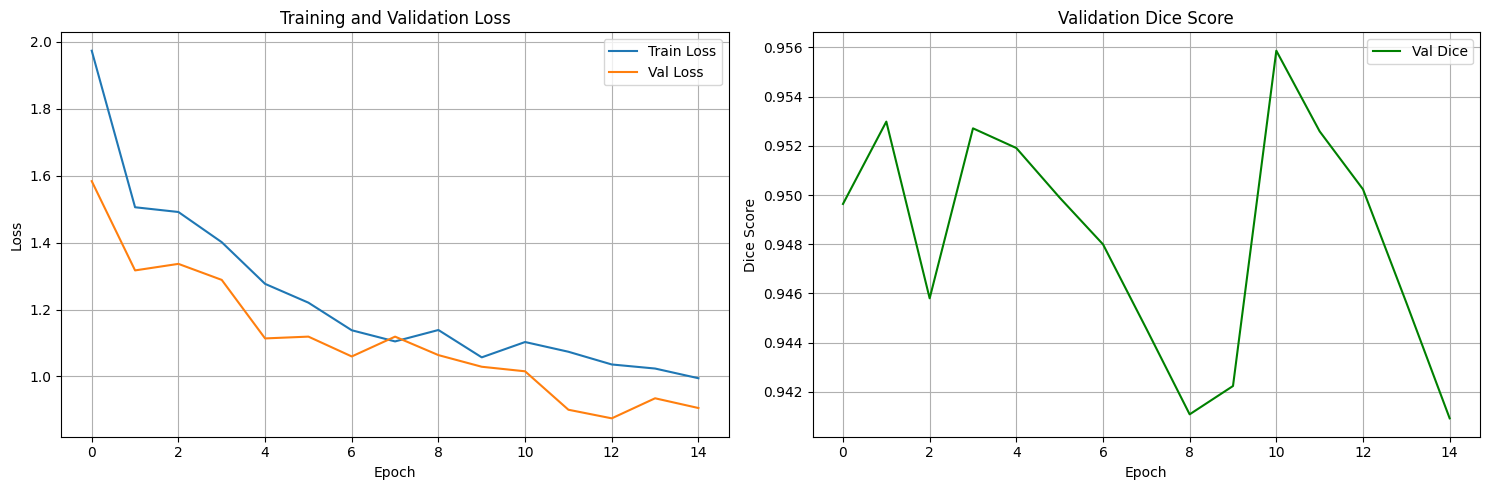

In [ ]:
# ------------------------------------------------------------------
# 14 Plot Training History
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['val_dice'], label='Val Dice', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Validation Dice Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(Config.OUTPUT_DIR / 'training_history.png', dpi=150)
print("Training history saved!")


In [ ]:
# ------------------------------------------------------------------
# 15 Final Evaluation
# ------------------------------------------------------------------
print("\nFinal evaluation on validation set...")
model = torch.load("./checkpoints/best_model.pth", weights_only=False)
final_results = validate(model, val_loader, Config.NUM_EPOCHS)

print(f"\n{'='*60}")
print("FINAL RESULTS")
print(f"{'='*60}")
print(f"Mean Dice Score: {final_results['dice_mean']:.4f}")
print(f"Teeth Dice Score: {final_results['dice_teeth']:.4f}")
print(f"Anatomical Dice Score: {final_results['dice_anatomical']:.4f}")
print(f"{'='*60}")

# Save detailed results
np.save(Config.OUTPUT_DIR / 'dice_per_class.npy', final_results['dice_per_class'])
print("Results saved!")



🔍 Final evaluation on validation set...


Validation:   0%|          | 0/96 [00:00<?, ?it/s]


📊 FINAL RESULTS
Mean Dice Score: 0.9515
Teeth Dice Score: 0.9714
Anatomical Dice Score: 0.8589
💾 Results saved!
